# Test implementation and analysis of distance and average-based fitting

In [1]:
# system libraries
from math import exp
# third party packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

# increase dpi and use latex rendering
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

# global constants for this notebook
E = 5.0
KAPPA = 0.41
TOLERANCE=1.0E-8
NEWTON = "Newton"
BISECTION = "Bisection"

## 1. Spalding's law of the wall

In [2]:
def spaldings_law(u_plus, E=E, kappa=KAPPA):
    """Evaluate Spalding's law of the wall.
    
    Parameters
    ----------
    u_plus - float: velocity along surface at distance y_plus in wall units
    E - float: wall roughness parameter
    kappa - float: von Kármán constant
    
    Returns
    -------
    y_plus - float: distance normal to wall in wall units
    
    """
    return u_plus + 1.0/E * (
        exp(kappa*u_plus) - 1.0 - kappa*u_plus - (kappa*u_plus)**2/2.0 - (1/6)*(kappa*u_plus)**3/6.0
    )

u_plus = np.linspace(0, 20, 100)
y_plus = np.array([spaldings_law(up) for up in u_plus])

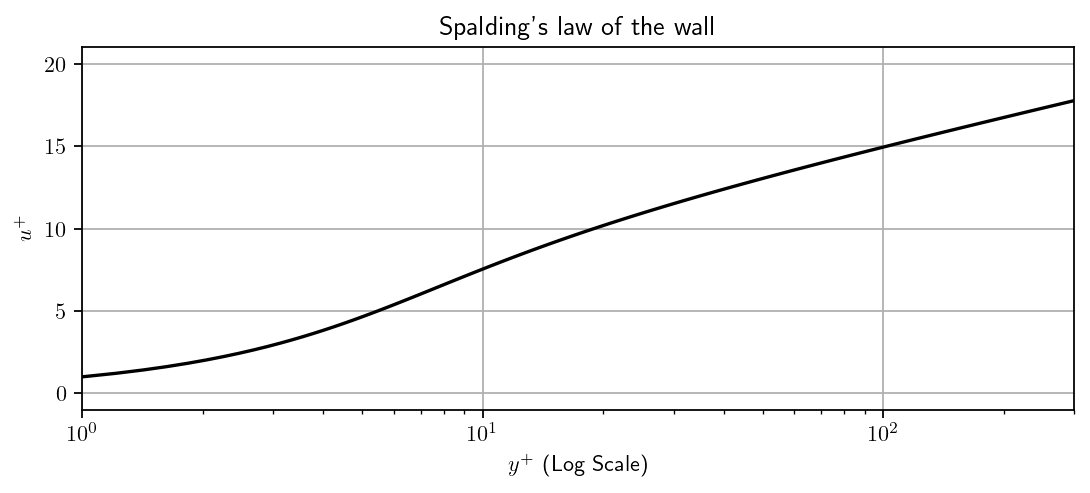

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))    

ax.plot(y_plus, u_plus, color="k")
ax.set_xlabel(r"$y^+$ (Log Scale)")
ax.set_ylabel(r"$u^+$")
ax.grid(True)
ax.set_xscale("log")
ax.set_xlim(1, 300)
ax.set_title(r"Spalding's law of the wall")

plt.show()

## 2. Average-based fitting

The average-based fitting consists of three steps:
1. Approximating the velocity $u(y)$ at a given distance $y$ normal to the wall and given wall shear stress velocity $u_\tau$ according to Spalding's law
2. Averaging the velocity profile over the cell width $L$:
$$
  \langle u(u_\tau) \rangle_y = \frac{1}{L}\int\limits_{y=0}^L u(y, u_\tau) \mathrm{d}y
$$
3. Computing $u_\tau$ using the finit volume-based cell velocity $u_p$ such that:
$$
  u_p \overset{!}{=} \langle u(u_\tau) \rangle_y
$$

### 2.1 Inverting Spalding's function to obtain the velocity

In [4]:
def spalding_velocity(y, u_tau, nu, method=NEWTON, tolerance=TOLERANCE, max_iter=100, E=E, kappa=KAPPA, verbose=False):
    """Invert Spalding's law to compute physical velocity.
    
    Spalding's law provides a relationship between the distance normal
    to the wall and the velocity along the wall in wall units. If the
    task is to compute the velocity with physical units for a given distance
    from the wall, it is not possible to invert Spalding's law analytically.
    This function computes the inverse relationship numerically using either
    Newton's method or bisection.
    
    Parameters
    ----------
    y - float: distance normal to the wall in [m]
    u_tau - float: wall shear stress velocity in [m/s]
    nu - float: kinematic viscosity in [m^2/s]
    method - string: can be either NEWTON or BISECTION
    tolerance - float: tolerance for iterative inversion
    max_iter - int: maximum allowed number of iterations
    E - float: wall roughness parameter
    kappa - float: von Kármán constant
    verbose - bool: if True, additional information is displayed
    
    Returns
    -------
    u - float: velocity along the wall at distance y in [m/s]
    
    """
    u = u_tau
    n_iter = 0
    residual = 1.0
    if method == NEWTON:
        while residual > tolerance and n_iter < max_iter:
            f = spaldings_law(u/u_tau) - y*u_tau/nu
            df = 1.0/u_tau + 1.0/E * (
                kappa/u_tau*exp(kappa*u/u_tau) - kappa/u_tau - (kappa**2/u_tau**2)*u - 1/2*(kappa**3/u_tau**3)*(u**2)
            )
            u_new = u - f/df
            residual = abs(u - u_new)
            u = u_new
            n_iter += 1
    elif method == BISECTION:
        u_upper = u_tau * 100.0
        u_lower = 0.0
        while residual > tolerance and n_iter < max_iter:
            u = 0.5 * (u_upper + u_lower)
            f_upper = spaldings_law(u_upper/u_tau) - y*u_tau/nu
            f_center = spaldings_law(u/u_tau) - y*u_tau/nu
            if f_center * f_upper > 0.0:
                u_upper = u
            else:
                u_lower = u
            residual = abs(f_center)
            n_iter += 1
            
    if verbose:
        if n_iter < max_iter:
            print(f"{method} method converged in {n_iter} iterations.")
        else:
            print(f"{method} method did not converge in {max_iter} iterations.")
            print("Final residual (tolerance): {:2.4e} ({:2.4e})".format(residual, tolerance))
    return u


def spalding_utau(y, u, nu, method=NEWTON, tolerance=TOLERANCE, max_iter=100, E=E, kappa=KAPPA, verbose=False):
    """Invert Spalding's law to compute physical velocity (u_tau).
    
    Spalding's law provides a relationship between the distance normal
    to the wall and the velocity along the wall in wall units. If the
    task is to compute the velocity with physical units for a given distance
    from the wall, it is not possible to invert Spalding's law analytically.
    This function computes the inverse relationship numerically using either
    Newton's method or bisection. This function is used for mimicking the
    function 'calcUTau' in OpenFOAM.
    
    Parameters
    ----------
    y - float: distance normal to the wall in [m]
    u - float: velocity along the wall at distance y in [m/s]
    nu - float: kinematic viscosity in [m^2/s]
    method - string: can be either NEWTON or BISECTION
    tolerance - float: tolerance for iterative inversion
    max_iter - int: maximum allowed number of iterations
    E - float: wall roughness parameter
    kappa - float: von Kármán constant
    verbose - bool: if True, additional information is displayed
    
    Returns
    -------    
    u_tau - float: wall shear stress velocity in [m/s]
    
    """
    u_tau = u
    n_iter = 0
    residual = 1.0
    if method == NEWTON:
        while residual > tolerance and n_iter < max_iter:
            f = spaldings_law(u/u_tau) - y*u_tau/nu            
            df = -(y/nu) - 1.0*u/(u_tau)**2 + 1.0/E * (
                -kappa*u/(u_tau**2)*exp(kappa*u/u_tau) + kappa*u/u_tau**2 - (kappa*u/u_tau)*(-kappa*u/u_tau**2) 
                - 1/2*((kappa*u/u_tau)**2)*(-kappa*u/u_tau**2)
            )
            utau_new = u_tau - f/df
            residual = abs(u_tau - utau_new)
            u_tau = utau_new
            n_iter += 1
    elif method == BISECTION:
        utau_upper = u * 100.0
        utau_lower = 0.0
        while residual > tolerance and n_iter < max_iter:
            u_tau = 0.5 * (utau_upper + utau_lower)
            f_upper = spaldings_law(u/utau_upper) - y*utau_upper/nu
            f_center = spaldings_law(u/u_tau) - y*u_tau/nu
            if f_center * f_upper > 0.0:
                utau_upper = u_tau
            else:
                utau_lower = u_tau
            residual = abs(f_center)
            n_iter += 1
            
    if verbose:
        if n_iter < max_iter:
            print(f"{method} method converged in {n_iter} iterations.")
        else:
            print(f"{method} method did not converge in {max_iter} iterations.")
            print("Final residual (tolerance): {:2.4e} ({:2.4e})".format(residual, tolerance))
    return u_tau

In [5]:
## test of the function "spalding_velocity"
u_expected = 20.0  # in [m/s]
u_tau = 2.0        # in [m/s]
nu = 1.0E-5        # in [m^2/s]
# physical distance in [m]
y = spaldings_law(u_expected/u_tau) * nu / u_tau

# test Newton's method
u_computed = spalding_velocity(y, u_tau, nu, verbose=True)
assert abs(u_expected - u_computed) < TOLERANCE

# test Bisection method
u_computed = spalding_velocity(y, u_tau, nu, method=BISECTION, verbose=True)
assert abs(u_expected - u_computed) < TOLERANCE

Newton method converged in 14 iterations.
Bisection method converged in 35 iterations.


### 2.2 Computing the average velocity

In [6]:
def average_velocity(yf, u_tau, nu, method, tolerance=TOLERANCE, max_iter=100, E=E, kappa=KAPPA, verbose=False,
                     num_points=50):
    """Execute a numerical integration method to calculate a new average velocity.
    
    In order to find the average velocity, a numerical integration method is
    to be employed. Here, Trapezoidal rule is used for the numerical integration.
    For each integration point, the information of velocity is needed. This 
    velocity information is obtained from the calculation of the function
    'spalding_velocity'. After the velocity is found for each integral points,
    the numerical integration by Trapezoidal rule is executed with either Newton's
    method or bisection method.
    
    Parameters
    ----------
    yf - float: cell height normal to the wall in [m]
    u_tau - float: wall shear stress velocity in [m/s]
    nu - float: kinematic viscosity in [m^2/s]
    method - string: can be either NEWTON or BISECTION
    tolerance - float: tolerance for iterative inversion
    max_iter - int: maximum allowed number of iterations
    E - float: wall roughness parameter
    kappa - float: von Kármán constant
    verbose - bool: if True, additional information is displayed
    num_points - int: number of integration points
    
    Returns
    -------
    u_avg - float: new average velocity of one cell in [m/s]
    
    """
    
    # divide the cell height into the number of points
    y = np.linspace(0.0, yf, num_points+1)
    
    # sum of trapezoidal parts
    trap_sum = 0
    
    if method == NEWTON:
        for i in range(num_points):
            trap_sum += spalding_velocity(y[i], u_tau, nu, NEWTON, TOLERANCE, max_iter, E, KAPPA, verbose) + \
                        spalding_velocity(y[i+1], u_tau, nu, NEWTON, TOLERANCE, max_iter, E, KAPPA, verbose)
            
        # u_avg is the new cell center velocity by the method.
        u_avg = 1/2*(1/num_points)*trap_sum        
        
    if method == BISECTION:
        for i in range(num_points):
            trap_sum += spalding_velocity(y[i], u_tau, nu, BISECTION, TOLERANCE, max_iter, E, KAPPA, verbose) + \
                        spalding_velocity(y[i+1], u_tau, nu, BISECTION, TOLERANCE, max_iter, E, KAPPA, verbose)
                
        u_avg = 1/2*(1/num_points)*trap_sum
        
    return u_avg

In [7]:
## test of the function "average_velocity"
u = 20.0        # in [m/s]
u_tau = 2.0     # in [m/s]
nu = 1.0E-5     # in [m^2/s]
# physical distance in [m]
y = spaldings_law(u/u_tau) * nu / u_tau

# test Newton's method
u_avg_computed = average_velocity(2*y, u_tau, nu, method=NEWTON, verbose=False, num_points=50)
print("Newton's method : u_avg_computed = {:.6}".format(u_avg_computed))

# test Bisection method
u_avg_computed_bi = average_velocity(2*y, u_tau, nu, method=BISECTION, verbose=False, num_points=50)
print("Bisection method : u_avg_computed = {:.6}".format(u_avg_computed_bi))

# comparison of the results of two methods
assert abs(u_avg_computed - u_avg_computed_bi) < TOLERANCE

Newton's method : u_avg_computed = 17.7801
Bisection method : u_avg_computed = 17.7801


### 2.3 Computing $u_\tau$

In [8]:
def compute_utau(yf, u_tau_init, u_sim, nu, method, tolerance=TOLERANCE, max_iter=100, E=E, kappa=KAPPA, 
                 verbose=False, num_points=10):
    """Compute u_tau from the new average velocity information by using Secant method.
    
    This function provides a new u_tau value, where the equation 'u_avg = u_sim' holds.
    In this case, the function for Secant method should be 'f = u_avg - u_sim' 
    (It has a root at 'f = 0'), where u_avg is found from the function 'average_velocity'.
    Then, the numerical method will converge to the point of 'u_avg = u_sim'. 
    Here, the function f corresponds to 'diff'.
    
    Parameters
    ----------
    yf - float: cell height normal to the wall in [m]
    u_tau_init - float: initial wall shear stress velocity in [m/s]
    u_sim - float: velocity along the wall from the simulation in [m/s]
    nu - float: kinematic viscosity in [m^2/s]
    method - string: can be either NEWTON or BISECTION
    tolerance - float: tolerance for iterative inversion
    max_iter - int: maximum allowed number of iterations
    E - float: wall roughness parameter
    kappa - float: von Kármán constant
    verbose - bool: if True, additional information is displayed
    num_points - int: number of integration points
    
    Returns
    -------
    u_tau - float: calculated wall shear stress velocity in [m/s]
    
    """
    
    # given initial u_tau values
    u_tau_old1 = u_tau_init
    u_tau_old2 = 20    
    
    # diff = u_avg - u_sim
    diff = 10    
    n_iter = 0    
    
    if method == NEWTON:
        diff_old1 = average_velocity(yf, u_tau_old1, nu, method=NEWTON, tolerance=TOLERANCE, max_iter=max_iter, 
                                     E=E, kappa=kappa, verbose=False, num_points=num_points) - u_sim
        diff_old2 = average_velocity(yf, u_tau_old2, nu, method=NEWTON, tolerance=TOLERANCE, max_iter=max_iter,
                                     E=E, kappa=kappa, verbose=False, num_points=num_points) - u_sim
        
        while(abs(diff)/u_sim > TOLERANCE):
            # By Secant method, we are able to find u_tau without using Spalding's function.
            # This method needs two previous status.
            u_tau = u_tau_old1 - diff_old1*(u_tau_old1 - u_tau_old2)/(diff_old1 - diff_old2 + 1.0E-8)
            
            diff = average_velocity(yf, u_tau, nu, method=NEWTON, tolerance=TOLERANCE, max_iter=max_iter,
                                    E=E, kappa=kappa, verbose=False, num_points=num_points) - u_sim
            
            diff_old2 = diff_old1
            u_tau_old2 = u_tau_old1
            diff_old1 = diff
            u_tau_old1 = u_tau
            
            n_iter += 1
            
    if method == BISECTION:
        diff_old1 = average_velocity(yf, u_tau_old1, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=max_iter,
                                     E=E, kappa=kappa, verbose=False, num_points=num_points) - u_sim
        diff_old2 = average_velocity(yf, u_tau_old2, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=max_iter,
                                     E=E, kappa=kappa, verbose=False, num_points=num_points) - u_sim
        
        while(abs(diff)/u_sim > TOLERANCE):            
            u_tau = u_tau_old1 - diff_old1*(u_tau_old1 - u_tau_old2)/(diff_old1 - diff_old2 + 1.0E-8)
            
            diff = average_velocity(yf, u_tau, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=max_iter,
                                    E=E, kappa=kappa, verbose=False, num_points=num_points) - u_sim
            
            diff_old2 = diff_old1
            u_tau_old2 = u_tau_old1
            diff_old1 = diff
            u_tau_old1 = u_tau
            
            n_iter += 1
    
    if verbose:
        if n_iter < max_iter:
            print(f"{method} method converged in {n_iter} iterations.")
        else:
            print(f"{method} method did not converge in {max_iter} iterations.")
            print("Final residual (difference): {:2.4e} ({:2.4e})".format(diff, tolerance))
            
    return u_tau

In [9]:
## test of the function "compute_utau"
u_sim = 20.0         # in [m/s]
u_tau_init = 2.0     # in [m/s]
nu = 1.0E-5          # in [m^2/s]
# physical distance in [m]
y = spaldings_law(u_sim/u_tau_init) * nu / u_tau_init

# test Newton's method
u_tau_computed = compute_utau(2*y, u_tau_init, u_sim, nu, method=NEWTON, tolerance=TOLERANCE, max_iter=100, 
                              verbose=True, num_points=50)
print("Newton's method : u_tau_computed = {:.6}".format(u_tau_computed))

# test Bisection method
u_tau_computed_bi = compute_utau(2*y, u_tau_init, u_sim, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=100, 
                                 verbose=True, num_points=50)
print("Bisection method : u_tau_computed = {:.6}".format(u_tau_computed_bi))

# comparison of the results of two methods
assert abs(u_tau_computed - u_tau_computed_bi) < TOLERANCE

Newton method converged in 4 iterations.
Newton's method : u_tau_computed = 2.17959
Bisection method converged in 4 iterations.
Bisection method : u_tau_computed = 2.17959


## 3. Plot

### 3.1 Plot Spalding's law for various $u_\tau$ with respect to $u$ and $y$

The relation ```u_tau = sqrt(tau_w) = sqrt(nu*(du/dy))``` is applicable for incompressible flows. As seen below, the gradient $\frac{du}{dy}$ increases as $u_\tau$ increases. Therefore, the behavior of Spalding's law is reasonable.

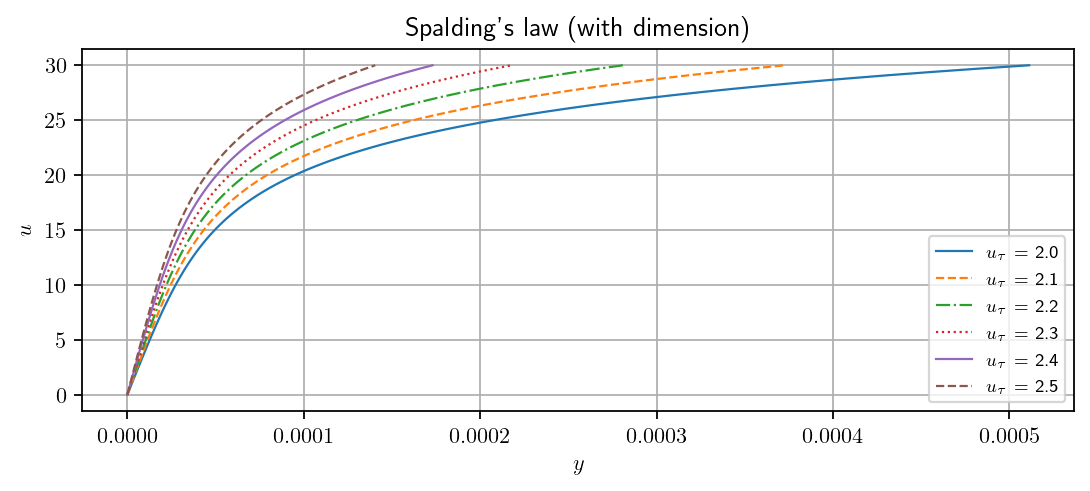

In [10]:
# nu from Turbulent Flat Plate case
nu = 1.0E-5                           # in [m^2/s]
u_tau_list = [0.1*i+2 for i in range(6)] # in [m/s]
u_list = np.linspace(0, 30, 100)         # in [m/s]

style = ["-", "--", "-.", ":", "-", "--", "-.", ":"]
lw = 1.0
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax2.set_xlabel(r"$y$")
ax2.set_ylabel(r"$u$")
plt.title(r"Spalding's law (with dimension)")
for i in range(len(u_tau_list)):
    y = np.array([spaldings_law(u/u_tau_list[i]) * nu / u_tau_list[i] for u in u_list])
    ax2.plot(y, u_list, label = r'$u_\tau$ = {}'.format(u_tau_list[i]), ls = style[i], c = "C{:d}".format(i), lw = lw)
    ax2.legend(fontsize = 8)

### 3.2 Plot new average velocity for various $u_\tau$

For integration, Trapezoidal rule is used, and each velocity point is calculated by the numerical methods. Consequently, we are able to find the solution of this integral method. As seen below, there is no visible discrepancy of behavior between Newton's method and Bisection method if an initial interval [a, b] is long enough. It can be observed that the new velocity increases as $u_\tau$ increases. This graph will be used at a later section which is related to finding $u_\tau$ by the integral fitting method.

In [11]:
# new u_tau_list with linear space to plot continuous u_avg
u_tau_list = np.linspace(1, 20, 100) # in [m/s]
u = 20.0                             # in [m/s]
nu = 1.0E-5                          # in [m^2/s]
# arbitrary cell height in [m]
yf = 1.0E-5

# obtain the result of Newton's method
u_avg = np.array([average_velocity(yf, u_tau, nu, method=NEWTON, verbose=False, num_points=50) for u_tau in u_tau_list])

# obtain the result of Bisection method
u_avg_bi = np.array([average_velocity(yf, u_tau, nu, method=BISECTION, verbose=False, num_points=50) for u_tau in u_tau_list])

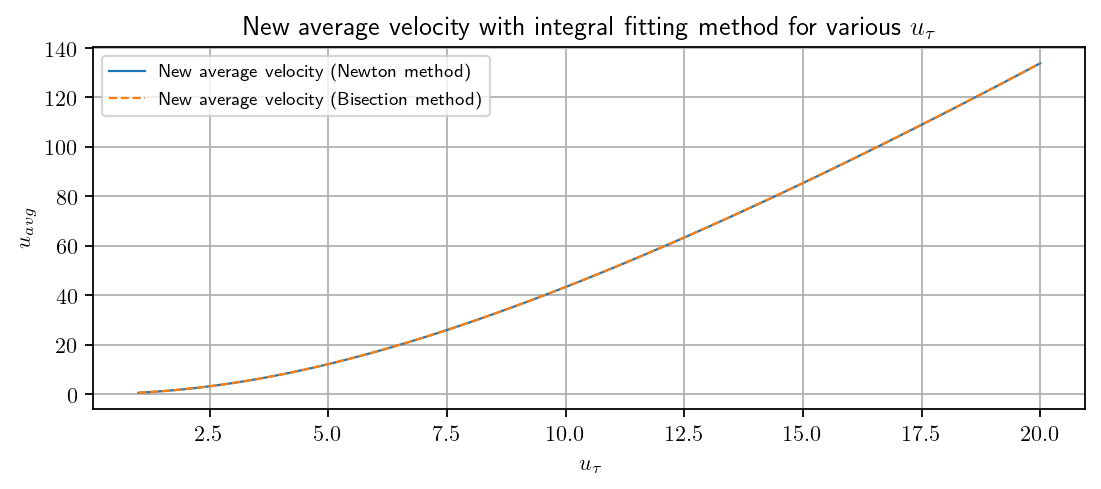

In [12]:
style2 = ["-", "--"]
lw2 = 1.0
# New average velocity plot
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax3.set_xlabel(r"$u_\tau$")
ax3.set_ylabel(r'$u_{avg}$')
plt.title(r"New average velocity with integral fitting method for various $u_\tau$")
ax3.plot(u_tau_list, u_avg, label = r'New average velocity (Newton method)', ls = style2[0], 
         c = "C{:d}".format(0), lw = lw2)
ax3.plot(u_tau_list, u_avg_bi, label = r'New average velocity (Bisection method)', ls = style2[1], 
         c = "C{:d}".format(1), lw = lw2)
ax3.legend(fontsize = 8)

### 3.3 Plot new average velocity for different number of integral points

According to the figure below, $u_{avg}$ value is consistent in terms of the number of integral points.

In [13]:
# fixed u_tau
u_tau = 2.0    # in [m/s]
u = 20.0       # in [m/s]
nu = 1.0E-5    # in [m^2/s]
# arbitrary cell height in [m]
yf = 1.0E-5

# list of the number of integral points
num_points_list = np.array([k for k in range(5, 26)])

# obtain the result of Newton's method
u_avg = np.array([average_velocity(yf, u_tau, nu, method=NEWTON, verbose=False, num_points=num_points) 
                  for num_points in num_points_list])

# obtain the result of Bisection method
u_avg_bi = np.array([average_velocity(yf, u_tau, nu, method=BISECTION, verbose=False, num_points=num_points) 
                     for num_points in num_points_list])

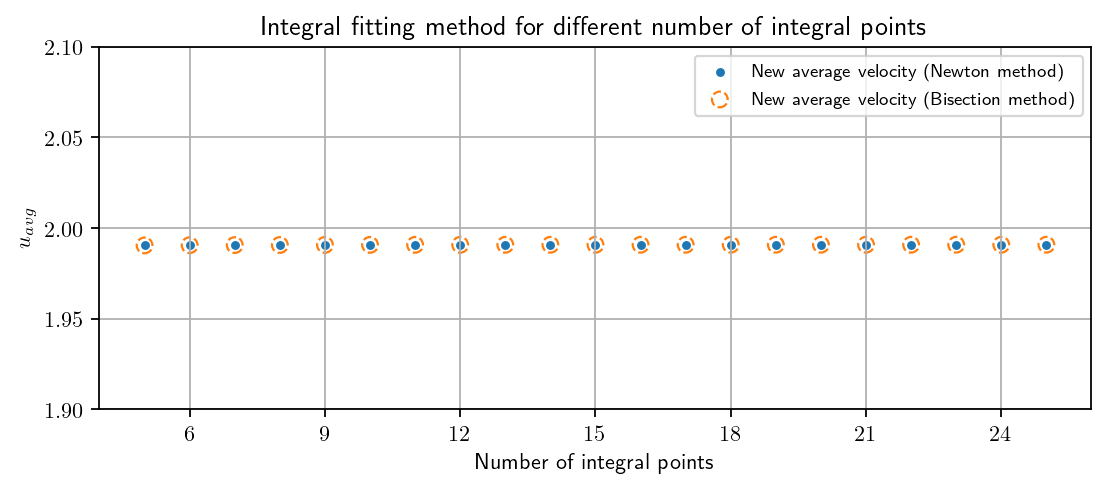

In [14]:
style3 = ["-", "--"]
lw3 = 1.0

fig4, ax4 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([1.9, 2.1])
plt.grid()
ax4.set_xlabel("Number of integral points")
ax4.set_ylabel(r'$u_{avg}$')
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(r"Integral fitting method for different number of integral points")
ax4.scatter(num_points_list, u_avg, label = r'New average velocity (Newton method)', marker='.', ls = style3[0], 
            c = "C{:d}".format(0), lw = lw3)
ax4.scatter(num_points_list, u_avg_bi, label = r'New average velocity (Bisection method)', s = 50, facecolors = 'none', 
            edgecolors = "C{:d}".format(1), ls = style3[1], lw = lw3)
ax4.legend(fontsize = 8)

### 3.4 Plot new average velocity for different cell heights and $u_\tau$

Basically, $u_{avg}$ (the integral based cell center velocity) and $u$ (the distance based cell center velocity) are in a linear relation. Therefore, the behavior of $u_{avg}$ value for the various cell heights is very similar to that of the $u$ & $y$ relation graph. However, for large cell heights, Newton's method starts to diverge, whereas Bisection method keeps the stable behavior. Therefore, Bisection method is more robust than Newton's method.

In [15]:
# various cell heights in [m]
yf_list = np.linspace(0.0, 1e-3, 100)
# u_tau_list with linear space to plot continuous u_avg
u_tau_list = np.linspace(1, 6, 6) # in [m/s]
u = 20.0                          # in [m/s]
nu = 1.0E-5                       # in [m^2/s]

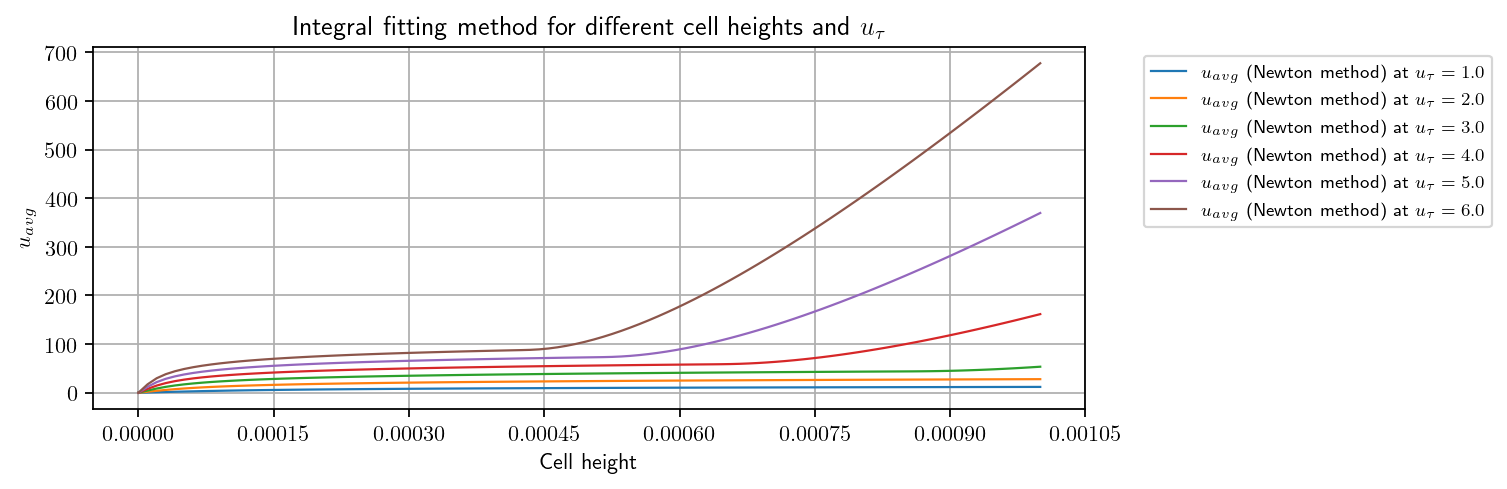

In [16]:
style4 = ["-", "--"]
lw4 = 1.0
# New mean velocity plot
fig5, ax5 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax5.set_xlabel("Cell height")
ax5.set_ylabel(r'$u_{avg}$')
ax5.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(r"Integral fitting method for different cell heights and $u_\tau$")
for j in range(len(u_tau_list)):
    # obtain the result of Newton's method
    u_avg = np.array([average_velocity(yf, u_tau_list[j], nu, method=NEWTON, verbose=False, num_points=50)
                      for yf in yf_list])
    ax5.plot(yf_list, u_avg, label = r'$u_{avg}$ ' + r'(Newton method) at $u_\tau = {:.1f}$'.format(u_tau_list[j]), 
             ls = style4[0], c = "C{:d}".format(j), lw = lw4)
    ax5.legend(fontsize = 8, bbox_to_anchor=(1.05, 1))

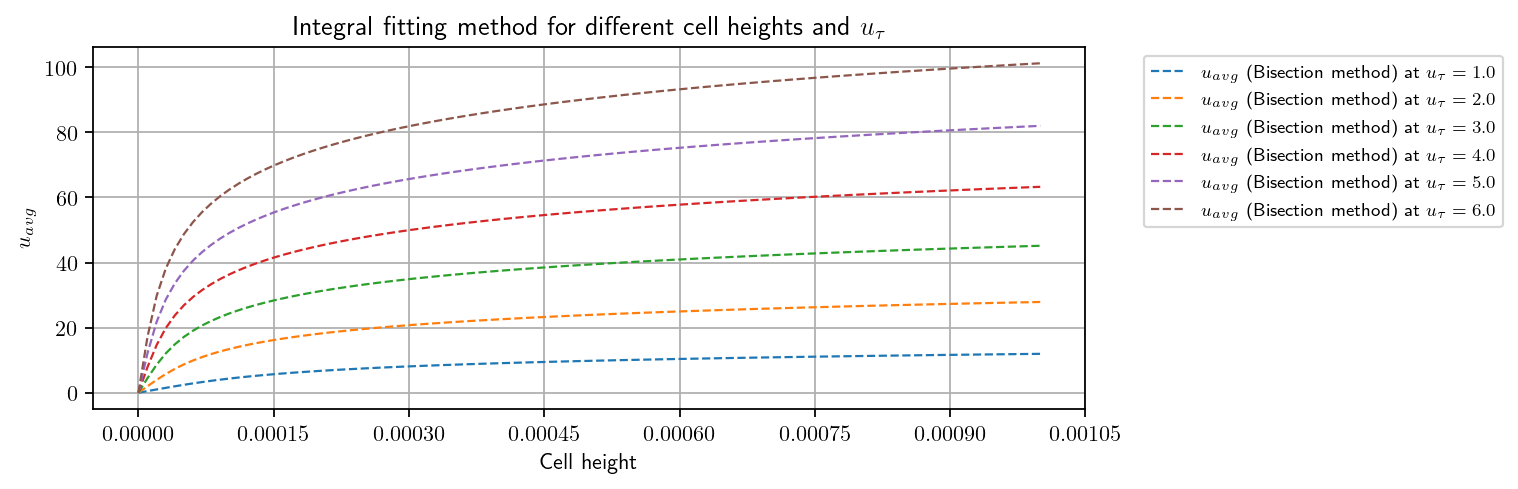

In [17]:
style5 = ["-", "--"]
lw5 = 1.0
# New mean velocity plot
fig6, ax6 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax6.set_xlabel("Cell height")
ax6.set_ylabel(r'$u_{avg}$')
ax6.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(r"Integral fitting method for different cell heights and $u_\tau$")
for j in range(len(u_tau_list)):
    # obtain the result of Bisection method
    u_avg_bi = np.array([average_velocity(yf, u_tau_list[j], nu, method=BISECTION, verbose=False, num_points=50) 
                         for yf in yf_list])
    ax6.plot(yf_list, u_avg_bi, label = r'$u_{avg}$ ' + r'(Bisection method) at $u_\tau = {:.1f}$'.format(u_tau_list[j]), 
             ls = style5[1], c = "C{:d}".format(j), lw = lw5)
    ax6.legend(fontsize = 8, bbox_to_anchor=(1.05, 1))

### 3.5 Plot for comparison of methods for obtaining $u_\tau$

In OpenFOAM, the function '*calcUTau*' exists for calculating $u_\tau$, while we use the integral fitting method. Each approach for finding $u_\tau$ is different as follows.

1. In '*calcUTau*' : The profile is explicitly set by Spalding's law that is used to obtain $u_\tau$.
2. Integral Method : The profile is set by the behavior of $u_{avg}$. In this case, Spalding's law is implicitly applied because it is used when $u_{avg}$ is calculated by the integral average method.

#### 3.5.1 $u_\tau$ for different velocities

The profile of the integral method is slightly different from the original '*calcUTau*' function, and thus it will yield a different result compared to the original one in OpenFOAM. In addition, the original function sometimes yields invalid values during the calculation (```RuntimeWarning``` message below), whereas the integral method does not have this problem. It implies that the integral method is more robust than the original method.

<ipython-input-4-2fab92c8e7e0>:46: RuntimeWarning: invalid value encountered in double_scalars
  f_upper = spaldings_law(u_upper/u_tau) - y*u_tau/nu
<ipython-input-4-2fab92c8e7e0>:47: RuntimeWarning: invalid value encountered in double_scalars
  f_center = spaldings_law(u/u_tau) - y*u_tau/nu


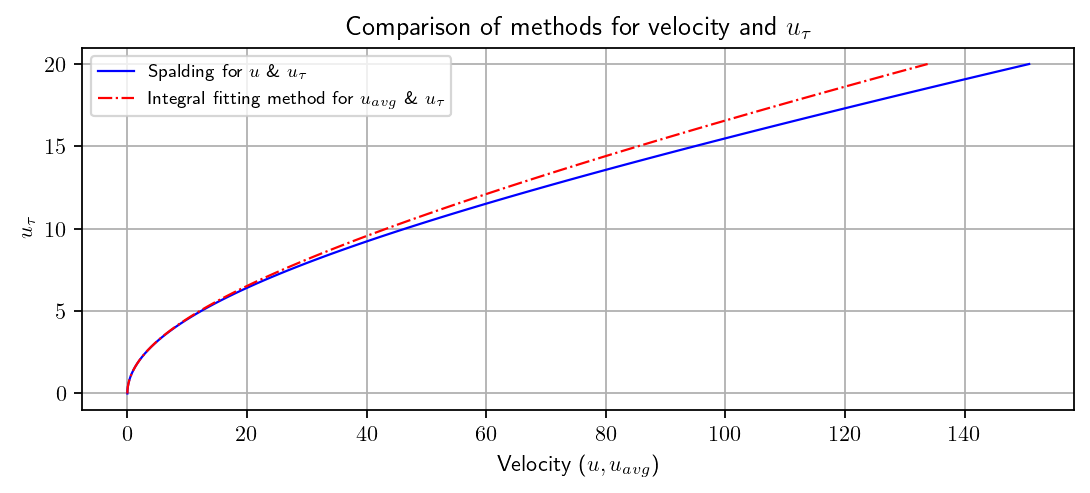

In [18]:
# list of velocities
u_tau_list = np.linspace(0, 20, 100) # in [m/s]

nu = 1.0E-5          # in [m^2/s]
yf_sim = 1.0E-5      # in [m]

# finding the relation of "u_tau & u" and "u_tau & u_avg", respectively
# relation of Spalding's law
u_list = [spalding_velocity(yf_sim/2, u_tau, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=100, E=E, 
                            kappa=KAPPA, verbose=False) for u_tau in u_tau_list]
# integral fitting method
u_avg_list = [average_velocity(yf_sim, u_tau, nu, method=BISECTION, verbose=False, num_points=50)
              for u_tau in u_tau_list]

style6 = ["-", "-."]
lw6 = 1.0
fig7, ax7 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax7.set_xlabel(r'Velocity ' + r'($u, u_{avg}$)')
ax7.set_ylabel(r'$u_\tau$')
plt.title(r"Comparison of methods for velocity and $u_\tau$")
ax7.plot(u_list, u_tau_list, label = r'Spalding for ' + r'$u$ \& $u_\tau$', ls = style6[0], c = 'b', lw = lw6)
ax7.plot(u_avg_list, u_tau_list, label = r'Integral fitting method for ' + r'$u_{avg}$ \& $u_\tau$', ls = style6[1], 
         c = 'r', lw = lw6)
ax7.legend(fontsize = 8)

#### 3.5.2 $u_\tau$ for different cell heights

Here, the following equation holds
$$
    u_\tau = \sqrt{\tau_w} = \sqrt{\nu\cdot\frac{du}{dy}}.
$$

According to the graph in 3.1, we can observe that the gradient $\frac{du}{dy}$ decreases as the cell height increases. Then, $u_\tau$ also decreases as the cell height increases because they have a quadratic relationship. $u_\tau$ from the integral fitting method is larger than that from Spalding's law.

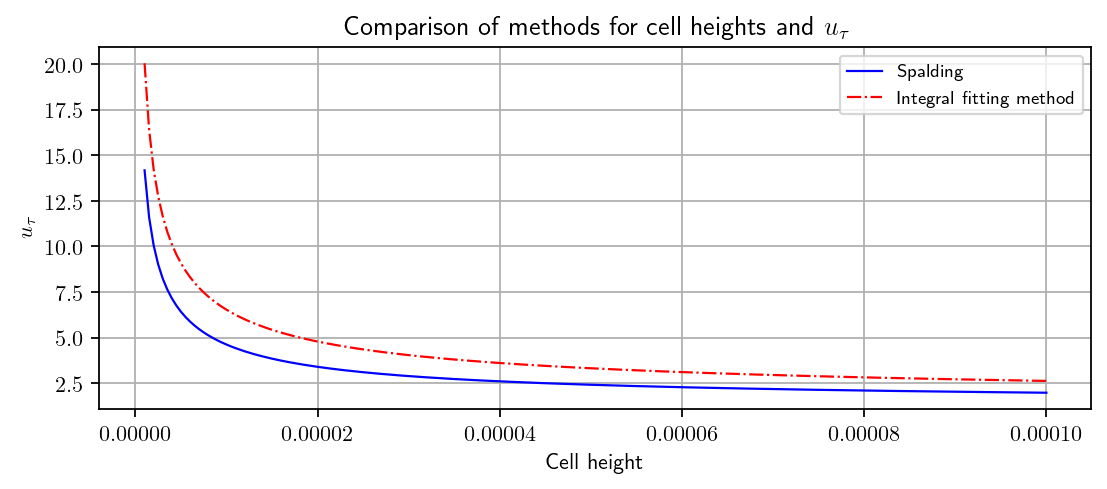

In [19]:
# various cell heights in [m]
yf_list = np.linspace(1e-6, 1e-4, 200)

u_sim = 20.0      # in [m/s]
nu = 1.0E-5       # in [m^2/s]
u_tau_init = 2.0  # in [m/s]

u_tau = np.array([spalding_utau(yf, u_sim, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=100, 
                            E=E, kappa=KAPPA, verbose=False) for yf in yf_list])
u_tau_avg = np.array([compute_utau(yf, u_tau_init, u_sim, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=100, 
                                   E=E, kappa=KAPPA, verbose=False, num_points=50) for yf in yf_list])

style7 = ["-", "-."]
lw7 = 1.0
fig8, ax8 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax8.set_xlabel(r'Cell height')
ax8.set_ylabel(r'$u_\tau$')
plt.title(r"Comparison of methods for cell heights and $u_\tau$")
ax8.plot(yf_list, u_tau, label = r'Spalding', ls = style7[0], c = 'b', lw = lw7)
ax8.plot(yf_list, u_tau_avg, label = r'Integral fitting method', ls = style7[1], c = 'r', lw = lw7)
ax8.legend(fontsize = 8)

#### 3.5.3 Derivative calculation at cell face for different cell heights

In [20]:
# various cell heights in [m]
yf_list = np.linspace(1e-6, 1e-4, 200)

nu = 1.0E-5       # in [m^2/s]
u_tau = 2.0       # in [m/s]

eps = 1.0E-8

# derivative calculation of distance based fitting and integral fitting
du_dy = [(spalding_velocity(yf+eps, u_tau, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=100, E=E, 
                            kappa=KAPPA, verbose=False)
          - spalding_velocity(yf-eps, u_tau, nu, method=BISECTION, tolerance=TOLERANCE, max_iter=100, E=E, 
                              kappa=KAPPA, verbose=False))/(2*eps) for yf in yf_list]
du_dy_avg = [(average_velocity(yf+eps, u_tau, nu, method=BISECTION, verbose=False, num_points=50)
              - average_velocity(yf-eps, u_tau, nu, method=BISECTION, verbose=False, num_points=50))/(2*eps)
              for yf in yf_list]

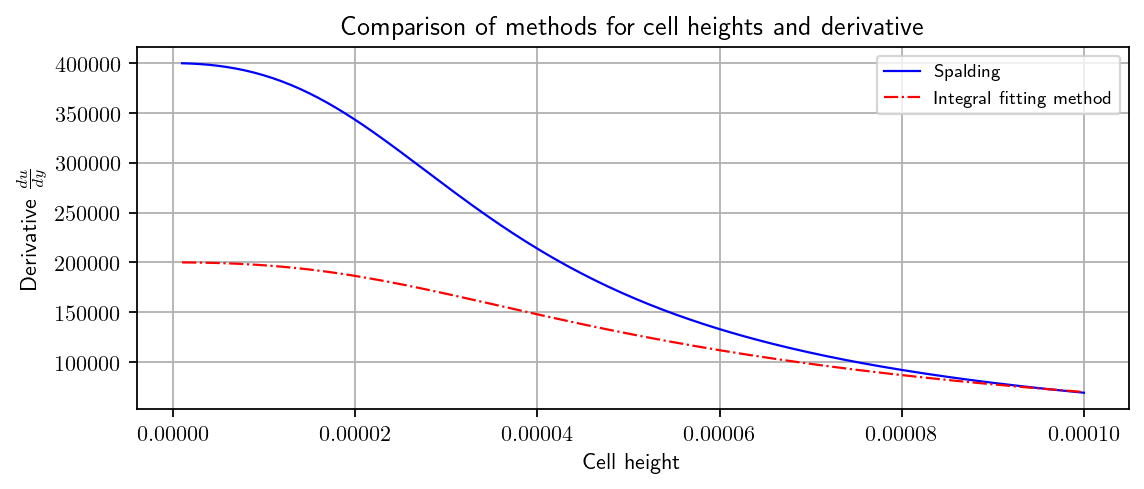

In [21]:
style8 = ["-", "-."]
lw8 = 1.0
fig9, ax9 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax9.set_xlabel(r'Cell height')
ax9.set_ylabel(r'Derivative $\frac{du}{dy}$')
plt.title(r"Comparison of methods for cell heights and derivative")
ax9.plot(yf_list, du_dy, label = r'Spalding', ls = style8[0], c = 'b', lw = lw8)
ax9.plot(yf_list, du_dy_avg, label = r'Integral fitting method', ls = style8[1], c = 'r', lw = lw8)
ax9.legend(fontsize = 8)